In [21]:
import pandas as pd
from Utility.toolbox import find_repo_root
root = find_repo_root()

In [22]:
df = pd.read_csv(f"{root}/Data/trope_time_series/10_things_i_hate.csv")

In [23]:
for i, x in enumerate(df['Trope'].tolist()):
    if type(x) != str:
        print(i, x, type(x))

In [24]:
df['Trope'] = df['Trope'].apply(lambda x: x.replace(" ", ''))


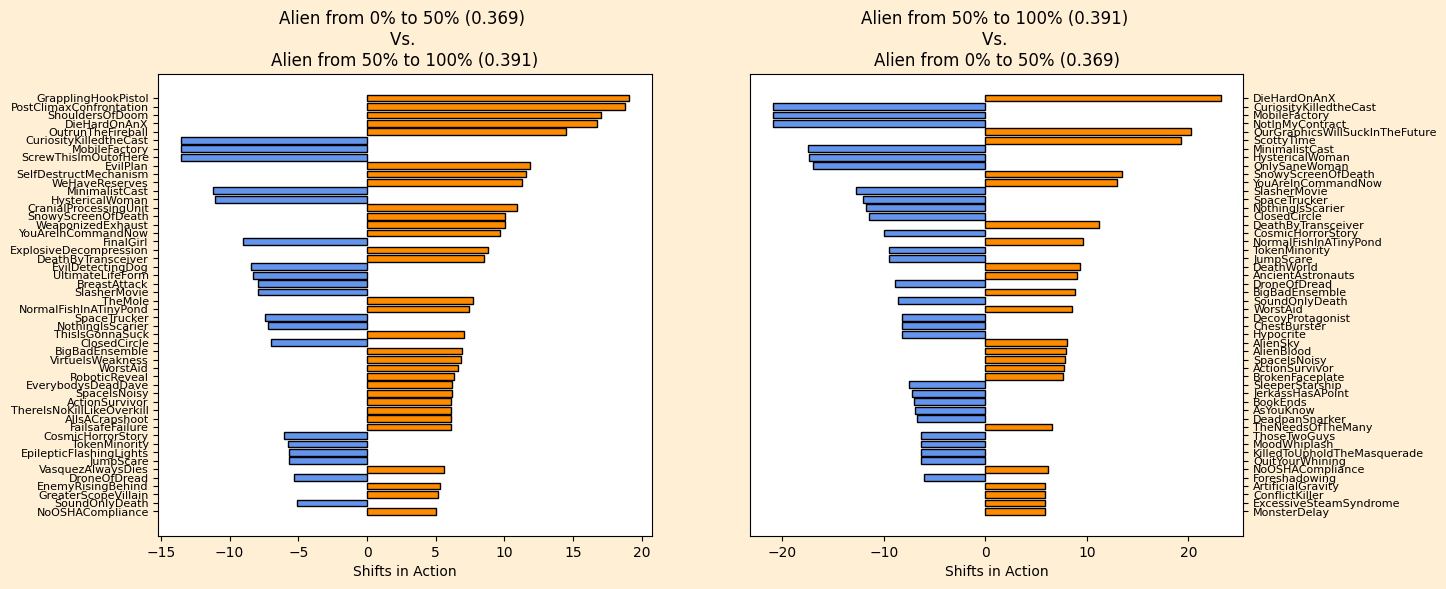

In [25]:
## project code for ease
from Utility.toolbox import find_repo_root, eval_pd_data_string_literal
from Utility.genre_trope_matrix import build_prop_trope_matrix
root = find_repo_root()

## extra libraries
import pandas as pd
from matplotlib import pyplot as plt



class genre_shifter:
    def __init__ (self):
        try:
            self.matrix_df = pd.read_csv(f"{root}/Code/Utility/genre_trope_matrix.py")
        except:
            self.matrix_df = build_prop_trope_matrix(norm="num_movies")
        self.tropeset = pd.read_csv(f"{root}/Data/general/movies-vs-tropes.csv", sep=';')
        self.tropeset['Tropes'] = self.tropeset['Tropes'].apply(lambda x : eval_pd_data_string_literal(x))

    def build_comp_ref_with_time(self, ref_file, ref_name, comp_file=None, comp_name=None):
        self.ref_name = ref_name
        self.ref_basis = self.build_with_time(ref_file)

        if comp_file:
            self.comp_name = comp_name
            self.comp_basis = self.build_with_time(comp_file)
        else:
            self.comp_name = self.ref_name
            self.comp_basis = self.ref_basis

    def build_with_time(self, file):
        df = pd.read_csv(file)
        df['Trope'] = df['Trope'].apply(lambda x: x.replace(" ", ''))
        df = df.merge(right=self.matrix_df, on='Trope', how='left')
        df = df[df['Trope'].notna()]
        df = self.scale_to_time(df)
        return df

    def scale_to_time(self, df, tau=600):
        end_second = df['End Time'].max()
        time_df = pd.DataFrame({'time': range(0, end_second + 1)})

        # get only the seconds that actually have tropes
        df['active_seconds'] = df.apply(lambda row: list(range(row['Start Time'], min(row['End Time'] + tau, end_second))), axis=1)
        df_exploded = df.explode('active_seconds').reset_index(drop=True)
        df_exploded = df_exploded.merge(time_df, left_on='active_seconds', right_on='time', how='left')

        # Group by active seconds and aggregrate
        genres = [col for col in self.matrix_df.columns if col != 'Trope']
        df_grouped = df_exploded.groupby('time').agg({
            'Trope': lambda x: list(set(x)),  # Keep unique tropes for each time as a list
            **{col: 'sum' for col in genres}  # Sum all genre columns
        }).reset_index()

        # Normalize genre columns to sum to 1
        df_grouped['total'] = df_grouped[genres].sum(axis=1)
        for col in genres:
            df_grouped[col] = df_grouped[col] / df_grouped['total']

        keep_cols = [col for col in df_grouped.columns if col in genres] + ['Trope', 'time']
        df_grouped = df_grouped[keep_cols]
        df_grouped['time'] = df_grouped['time'] / end_second
        return df_grouped
    

## chop up time series dfs into slices based on input
    def slice_times_and_average(self, ref_range, comp_range):
        self.ref_name += f" from {ref_range[0]*100:.0f}% to {ref_range[1]*100:.0f}%"
        self.comp_name +=f" from {comp_range[0]*100:.0f}% to {comp_range[1]*100:.0f}%"
        self.ref = self.ref_basis.loc[self.ref_basis['time'].between(ref_range[0], ref_range[1])]
        self.comp = self.comp_basis.loc[self.comp_basis['time'].between(comp_range[0], comp_range[1])]
        # print(f"Ref time range: {self.ref['time'].min()} to {self.ref['time'].max()}")
        # print(f"Comp time range: {self.comp['time'].min()} to {self.comp['time'].max()}")
        # print(self.comp_basis)
        
        # print(self.ref['Horror'].mean())
        # print(self.comp['Horror'].mean())
        self.ref = self.process_and_merge_tropes(self.ref)
        self.comp = self.process_and_merge_tropes(self.comp)
        # print(self.comp)




    def process_and_merge_tropes(self, df):
        """
        Processes a DataFrame by extracting unique tropes, cleaning up spaces, and merging with a matrix.
        """
        tropes = df['Trope'].explode().str.replace(" ", '').drop_duplicates()

        # Merge cleaned tropes with matrix
        trope_df = pd.DataFrame({'Trope': tropes}).sort_values(by='Trope')
        trope_df =  trope_df.merge(self.matrix_df, on='Trope', suffixes=[False, False])
        trope_df = trope_df.sort_values(by='Trope')
        return trope_df


    def reverse_comp_ref(self):
        self.ref_name, self.comp_name = self.comp_name, self.ref_name
        self.comp, self.ref = self.ref, self.comp

    def make_timeless_df(self, name):
        df = self.tropeset[self.tropeset['Movie'] == name].copy()
        df = df['Tropes'].apply(lambda x: pd.Series({value: 1 for value in x}))
        df = df.transpose().reset_index()
        df.columns = ['Trope', 'Value']
        df = df.merge(right=self.matrix_df, on='Trope', how='left').drop(columns='Value')
        df.dropna(inplace=True)

        return df

    def build_comp_ref_by_movie(self, ref_name, comp_name):
        self.ref_name = ref_name
        self.comp_name = comp_name
        self.ref = self.make_timeless_df(self.ref_name)
        self.comp = self.make_timeless_df(self.comp_name)
        self.ref, self.comp= self.ref[~self.ref['Trope'].isin(self.comp['Trope'])], self.comp[~self.comp['Trope'].isin(self.ref['Trope'])]

    def plot(self, genre, cutoff=None, ax=None, side='left'):
        ref_avg = self.ref[genre].mean()
        comp_avg = self.comp[genre].mean()

        # gen shifts columns and cutoff to get only largest
        self.shifts = self.comp.copy()
        self.shifts['shifts'] = (self.shifts[genre] - ref_avg) * (100 / (len(self.shifts) * abs(ref_avg - comp_avg)))
        self.shifts['shift_size'] = self.shifts['shifts'].abs()
        if cutoff:
            self.shifts = self.shifts.nlargest(cutoff, 'shift_size')
        self.shifts.sort_values(by='shift_size', inplace=True, ascending=False)

        shifts = list(self.shifts['shifts'])[::-1]
        tropes = list(self.shifts['Trope'])[::-1]
        # print(f"First few shifts: {shifts[:5]}")
        # print(f"First few tropes: {tropes[:5]}")
        
        ## actual plotting
        if ax is None:
            ax = plt.gca()

        bar_colors = ['darkorange' if v >= 0 else 'cornflowerblue' for v in shifts]
        
        # print(self.shifts['shifts'].apply(lambda x: type(x)).value_counts())  # To check the types of entries in the `shifts` column

        ax.barh(tropes, shifts, color=bar_colors, edgecolor='black')
        ax.set_xlabel(f'Shifts in {genre}')
        ax.set_title(f"{self.ref_name} ({ref_avg:.3f}) \nVs. \n{self.comp_name} ({comp_avg:.3f})")
        ax.tick_params(axis='y', labelsize=8)

        position_methods = {
        "left": (ax.yaxis.set_label_position, ax.yaxis.tick_left),
        "right": (ax.yaxis.set_label_position, ax.yaxis.tick_right),
         }
        label_pos, tick_pos = position_methods[side]
        label_pos(side)
        tick_pos()
        return ax

    def plot_two(self, movie1, movie2, genre, cutoff):
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor="papayawhip")

        self.build_comp_ref_by_movie(movie1, movie2)
        self.plot(genre, cutoff, ax=axes[0])

        self.reverse_comp_ref()  # Reverse comparison
        self.plot(genre, cutoff, ax=axes[1], side='right')

        plt.tight_layout()
        return fig


    def plot_comparison(self, genre, movie_file, movie_name, ref_range, comp_range):
        self.build_comp_ref_with_time(movie_file, movie_name)
        self.slice_times_and_average(ref_range, comp_range)
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor="papayawhip")
        self.plot(genre, cutoff=50, ax=axes[0])
        self.reverse_comp_ref()
        self.plot(genre, cutoff=50, ax=axes[1], side='right')
        return fig


if __name__== "__main__":
    gs = genre_shifter()
    gs.plot_comparison("Action", f"{root}/Data/trope_time_series/alien_tropes.csv", "Alien", (0, 0.5), (0.5, 1))